In [1]:
from torchvision.transforms import v2 as transforms

import lightning as pl
from lightning.pytorch.callbacks.model_summary import summarize
from lightning.pytorch.callbacks import ModelCheckpoint

from keyrover.datasets import *
from keyrover.homography import *
from keyrover import *

device = get_device()
device

2024-11-24 13:18:44.989 Python[33743:2316356] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


'mps'

In [2]:
image_paths = get_dataset_paths(base=f"{SEGMENTATION_DATASET}-nofisheye")
len(image_paths)

4999

In [3]:
train_paths, _, valid_paths = split_train_test_valid(image_paths, 1, 0.1)

SIZE = (256, 256)

train_dataset = KeyboardCornersDataset(train_paths, size=SIZE)
valid_dataset = KeyboardCornersDataset(valid_paths, size=SIZE)

len(train_dataset), len(valid_dataset)

  0%|          | 0/4500 [00:00<?, ?it/s]

Error decoding JSON from /Users/bhavyemathur/Library/Application Support/Ultralytics/settings.json. Starting with an empty dictionary.
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/Users/bhavyemathur/Library/Application Support/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


2024-11-24 13:18:51.673 Python[33761:2316528] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
2024-11-24 13:18:51.673 Python[33759:2316522] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
2024-11-24 13:18:51.673 Python[33757:2316498] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
2024-11-24 13:18:51.696 Python[33763:2316534] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
2024-11-24 13:18:51.908 Python[33760:2316525] WARNING: Secure coding is not enabled for restorab

  0%|          | 0/499 [00:00<?, ?it/s]

2024-11-24 13:19:01.505 Python[33814:2316988] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
2024-11-24 13:19:01.688 Python[33819:2317002] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
2024-11-24 13:19:01.866 Python[33822:2317030] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
2024-11-24 13:19:01.867 Python[33821:2317025] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
2024-11-24 13:19:01.907 Python[33820:2317022] WARNING: Secure coding is not enabled for restorab

(4500, 499)

In [4]:
mean, std = get_dataset_norm_params(version=3)
mean, std

test_transforms = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize(SIZE),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean, std),
])

train_dataset.set_augmentations([
    transforms.ToDtype(torch.float32, scale=True),
    transforms.GaussianNoise(sigma=0.01),
    transforms.RandomApply([transforms.GaussianNoise(sigma=0.01)], p=0.5),
    transforms.Normalize(mean, std),
])

valid_dataset.set_augmentations([
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean, std),
])

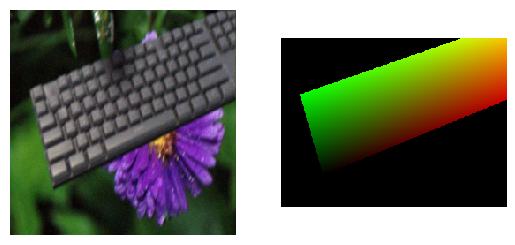

In [5]:
img, corners = train_dataset.random_img()

mean = torch.tensor([[121.73, 304.18, 521.91, 321.19, 518.25, 182.49, 135.07, 166.05]], device=device)
std = torch.tensor([[295.45, 322.01, 291.26, 333.85, 291.21, 329.92, 298.24, 317.73]], device=device)

corners = torch.tensor(corners, device=device) * std + mean
corners = tuple(*corners.reshape((1, 4, 2, 1)))

mask = corners_to_texture_coordinates(corners)[0]
imshow(img, mask)

In [6]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64

dl_kwargs = {"batch_size": BATCH_SIZE, "num_workers": 2, "persistent_workers": True, "pin_memory": False}

train_dataloader = DataLoader(train_dataset, **dl_kwargs, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, **dl_kwargs)

In [7]:
from torchvision import models


class CornersRegressionModel(pl.LightningModule):
    def __init__(self, lr: float | None = None) -> None:
        super().__init__()

        self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

        self.model.fc = torch.nn.Sequential(
            torch.nn.Linear(self.model.fc.in_features, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 8),
        )

        self.loss_fn = torch.nn.MSELoss()

        self.learning_rate = lr
        self.lr = self.learning_rate
        self.save_hyperparameters()

    def predict(self, image: torch.Tensor, mask: bool = True) -> np.ndarray:
        image = image.to(self.device)
        if len(image.shape) == 3:
            image = image.unsqueeze(0)

        with torch.no_grad():
            pred = self.forward(image, mask=mask).cpu().numpy()

        if len(pred) == 1:
            return pred[0,]
        return pred

    def forward(self, image: torch.Tensor, mask: bool = True) -> torch.Tensor:
        return self.model(image)

    def _step(self, batch: tuple[torch.Tensor, torch.Tensor], stage: str) -> float:
        image, target = batch
        predictions = self(image)

        loss = self.loss_fn(predictions, target)
        self.log(f"{stage}_loss", loss)
        return loss

    def training_step(self, batch: tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> float:
        return self._step(batch, "train")

    def validation_step(self, batch: tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> float:
        return self._step(batch, "val")

    def test_step(self, batch: tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> float:
        return self._step(batch, "test")

    def configure_optimizers(self) -> dict:
        optimizer = torch.optim.AdamW(self.parameters(), lr=(self.lr or self.learning_rate))
        return {"optimizer": optimizer}

In [8]:
import wandb
from lightning.pytorch.loggers import WandbLogger

wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: bhavye-mathur. Use `wandb login --relogin` to force relogin


True

In [30]:
LEARNING_RATE = 4e-4

wandb.finish()
model = CornersRegressionModel(lr=LEARNING_RATE)
model

NameError: name 'wandb' is not defined

In [38]:
summarize(model)

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | model   | ResNet  | 11.3 M | train
1 | loss_fn | MSELoss | 0      | train
--------------------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
45.302    Total estimated model params size (MB)
76        Modules in train mode
0         Modules in eval mode

In [ ]:
logger = WandbLogger(project="mrover-keyboard-corner-prediction")

checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min")

trainer = pl.Trainer(log_every_n_steps=1, logger=logger, max_time="00:08:00:00", callbacks=[checkpoint_callback])
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

In [45]:
torch.save(model.state_dict(), f"models/corner-prediction/{wandb.run.name}.pt")

CornersRegressionModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

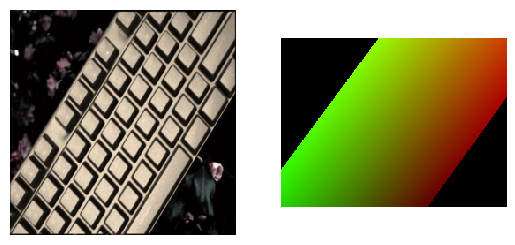

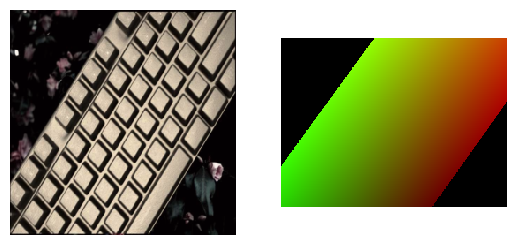

In [33]:
model.to(device)
model.eval()

img, corners = valid_dataset.random_img()
img = img.unsqueeze(0).to(device)

pred = model(img) * std + mean
pred = tuple(*pred.reshape((1, 4, 2, 1)))
pred = corners_to_texture_coordinates(pred)

corners = torch.tensor(corners, device=device) * std + mean
corners = tuple(*corners.reshape((1, 4, 2, 1)))
mask = corners_to_texture_coordinates(corners)

imshow(img[0], mask[0])
imshow(img[0], pred[0])

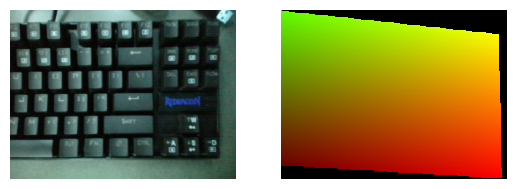

In [28]:
img = cv2.imread(f"{TEST_DATASET}/2-new.jpg")

img = test_transforms(img)
img = img.unsqueeze(0).to(device)

pred = model(img) * std + mean
pred = tuple(*pred.reshape((1, 4, 2, 1)))
pred = corners_to_texture_coordinates(pred)

img = img[0].cpu().numpy()
img = reorder_image_axes(img)
img = cv2.resize(img, (640, 480))
imshow(img, pred[0])